In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

#tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#CustomAdam definition
tf.config.run_functions_eagerly(True)
class CustomAdam(tf.keras.optimizers.Optimizer):
  def __init__(self, learning_rate=0.001,beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, name="CustomAdam", **kwargs):
    super().__init__(name, **kwargs)
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
    self._set_hyper("decay", self._initial_decay)
    self._set_hyper("beta_v", beta1)
    self._set_hyper("beta_s", beta2)
    self._set_hyper("epsilon", epsilon)
    self._set_hyper("corrected_v", beta1)
    self._set_hyper("corrected_s", beta2)
   
  def _create_slots(self, var_list):
    """
    One slot per model variable.
    """
    for var in var_list:
      self.add_slot(var, "beta_v")
      self.add_slot(var, "beta_s")
      self.add_slot(var, "epsilon")
      self.add_slot(var, "corrected_v")
      self.add_slot(var, "corrected_s")
       

  @tf.function
  def _resource_apply_dense(self, grad, var):
    """Update the slots and perform an optimization step for the model variable.
    """

    var_dtype = var.dtype.base_dtype
    lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
     
    momentum_var1 = self.get_slot(var, "beta_v")
    momentum_hyper1 = self._get_hyper("beta_v", var_dtype)
     
    momentum_var2 = self.get_slot(var, "beta_s")
    momentum_hyper2 = self._get_hyper("beta_s", var_dtype)
     
     
    momentum_var1.assign(momentum_var1 * momentum_hyper1 + (1. - momentum_hyper1)* grad)
     
    momentum_var2.assign(momentum_var2 * momentum_hyper2 + (1. - momentum_hyper2)* (grad ** 2))
     

    # Adam bias-corrected estimate
     
    corrected_v = self.get_slot(var, "corrected_v")
    corrected_v.assign(momentum_var1 / (1 - (momentum_hyper1 ** (self.iterations.numpy() + 1) )))

    corrected_s = self.get_slot(var, "corrected_s")
    corrected_s.assign(momentum_var2 / (1 - (momentum_hyper2 ** (self.iterations.numpy() + 1) )))

    epsilon_hyper = self._get_hyper("epsilon", var_dtype)
     
    var.assign_add(-lr_t * (corrected_v / (tf.sqrt(corrected_s) + epsilon_hyper)))

  def _resource_apply_sparse(self, grad, var):
    raise NotImplementedError

  def get_config(self):
    base_config = super().get_config()
    return {
      **base_config,
      "learning_rate": self._serialize_hyperparameter("learning_rate"),
      "decay": self._serialize_hyperparameter("decay"),
      "beta_v": self._serialize_hyperparameter("beta_v"),
      "beta_s": self._serialize_hyperparameter("beta_s"),
      "epsilon": self._serialize_hyperparameter("epsilon"),
    }


In [3]:
# works if vgg19.preprocess_input used for preprocessing
def deprocess_img(y):
  x = np.copy(y)
  # BGR
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  # BGR -> RGB
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [4]:
def load_img(path_to_img):
    max_dim = 512

    # loading
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_jpeg(img) #H,W,C
    img = tf.image.convert_image_dtype(img, tf.float32)

    # reshaping
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)

    #preprocessing for vgg
    img = img[tf.newaxis, :] # adding batch axis
    #img = tf.keras.applications.vgg19.preprocess_input(img * 255.)

    return img

In [5]:
content_img = load_img('images/tubingen.jpg')
style_img = load_img('images/kandinsky.jpg')


Metal device set to: AMD Radeon Pro 560X

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



2022-03-04 16:15:44.231069: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-04 16:15:44.231687: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-04 16:15:44.232022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<Figure size 432x288 with 0 Axes>

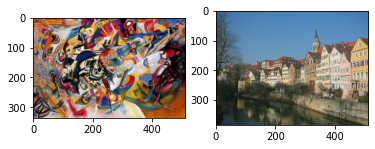

In [6]:
plt.figure()
_, ax = plt.subplots(1,2)

ax[0].imshow(style_img[0])
ax[1].imshow((content_img[0]))



In [7]:
base = tf.keras.applications.VGG19(include_top=False)

x = base.layers[0].output

for l_idx in range(1,len(base.layers)):
    current_layer = base.layers[l_idx]

    # replace max -> avg pool
    if isinstance(current_layer, tf.keras.layers.MaxPool2D):
        x = tf.keras.layers.AveragePooling2D(**current_layer.get_config())(x)
    else:
        x = current_layer(x)

vgg19= tf.keras.Model(inputs = base.layers[0].input, outputs = x)
vgg19.trainable = False

In [8]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

content_outputs = []
style_outputs = []
for layer in vgg19.layers:
    if layer.name in content_layers:
        content_outputs.append(layer.output)
    if layer.name in style_layers:
        style_outputs.append(layer.output)

In [9]:
model_content = tf.keras.Model(inputs = vgg19.input, outputs= content_outputs)
model_style = tf.keras.Model(inputs = vgg19.input, outputs= style_outputs)


content_repr = model_content(tf.keras.applications.vgg19.preprocess_input(content_img * 255.))
style_repr = model_style(tf.keras.applications.vgg19.preprocess_input(style_img * 255.))

In [10]:
def content_loss(content_repr,current_content_repr):
    channel_size = content_repr.shape[-1]
    f = tf.reshape(content_repr,[1,-1,channel_size])
    p = tf.reshape(current_content_repr,[1,-1,channel_size])

    return 0.5 * tf.reduce_sum(tf.pow(f - p,2))

def style_loss_layer(temp_style_repr,temp_current_style_repr):
    channel_size = temp_style_repr.shape[-1]
    temp_style_repr = tf.reshape(temp_style_repr,[1,-1,channel_size])
    _,ml,nl = temp_style_repr.shape
    temp_current_style_repr = tf.reshape(temp_current_style_repr,[1,-1,channel_size])

    g= tf.transpose(temp_style_repr,perm=[0,2,1]) @ temp_style_repr
    a= tf.transpose(temp_current_style_repr,perm=[0,2,1]) @ temp_current_style_repr

    return (1./(4 * ml**2 * nl**2)) * tf.reduce_sum(tf.pow(g - a,2))

def style_loss(style_repr,current_style_repr,style_layer_weights=None):

    # convert to list if only using 1 style repr
    if not isinstance(style_repr,list): 
        style_repr = [style_repr]
        current_style_repr = [current_style_repr]
    
    if style_layer_weights is None: # assign equal weight
        style_layer_weights = list(map(lambda x: (1./len(style_repr)),style_repr))
    
    total = 0
    for idx in range(len(style_repr)):
        total += style_layer_weights[idx] * style_loss_layer(style_repr[idx],current_style_repr[idx])

    return total


# borrowed from https://www.tensorflow.org/tutorials/generative/style_transfer
def variation_loss(img):
    x_deltas = img[:, :, 1:, :] - img[:, :, :-1, :]
    y_deltas = img[:, 1:, :, :] - img[:, :-1, :, :]
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [11]:
## ABOVE IS CONSTANT FROM NOW ON!

In [12]:
# DONE
# check for any mathematical bugs -done-
# reducing loss via setting alpha and beta so small -done, not working-
# do it on colab -done-
# normalize content and style images [-1,1]. use torch or tf initialization? (cancel noise initialization)
# using style repr, reconstruct style representations(fig1,style rec)
# 0- tf tutorial'i kendi gpu'nda calistir. 50 stepte image'in nasil degistigine bak
# 1 - compare tf loss functions with yours, experimentally. if yes, go to 2.
# better resizing 
# 2 - github look how people initialized and normalized their images. input noise range vs.
# 2- max pool -> avg pool

# NOW DO

# individual style representation

# TO DO

# weight normalization



In [13]:
# training loop

optimizer = CustomAdam(learning_rate=0.02, beta1=0.99, epsilon=1e-1)

# initialize with trainable noise
#noise_img= tf.Variable(initial_value=tf.random.normal(shape=content_img.shape,mean = np.mean(content_img),stddev = np.std(content_img)))
# OR
# initialize with content image
noise_img= tf.Variable(initial_value=content_img)

model_noise = tf.keras.Model(inputs = vgg19.input, outputs= style_outputs + content_outputs)


beta = 1 # style
alpha = 1e-4 # content
var_weigth = 30 # variation weight



EPOCHS = 1000

for e in range(EPOCHS):

    # training loop
    with tf.GradientTape() as tape:
        
        noise_repr = model_noise(tf.keras.applications.vgg19.preprocess_input(noise_img * 255.))
        current_content_repr = noise_repr[-1]
        current_style_repr = noise_repr[:-1]

        loss_c = alpha * content_loss(content_repr,current_content_repr)
        loss_s = beta * style_loss(style_repr,current_style_repr)
        loss_v = var_weigth * variation_loss(noise_img)
        loss = loss_s + loss_c + loss_v
    
    gradients = tape.gradient(loss,[noise_img])
    optimizer.apply_gradients(zip(gradients, [noise_img]))
    noise_img.assign(tf.clip_by_value(noise_img, clip_value_min=0., clip_value_max=1.))
    
    if e%100==0:
        print(f'epoch: {e}, content_loss: {loss_c.numpy()}, style_loss: {loss_s.numpy()}, variation_loss: {loss_v.numpy()}')
    matplotlib.image.imsave('created.jpg',np.array(noise_img[0]*255., dtype=np.uint8))


epoch: 0, content_loss: 0.0, style_loss: 21453758464.0, variation_loss: 1900050.125
epoch: 100, content_loss: 65054284.0, style_loss: 253778736.0, variation_loss: 4407254.5
epoch: 200, content_loss: 67130880.0, style_loss: 81202640.0, variation_loss: 4330713.0
epoch: 300, content_loss: 65050940.0, style_loss: 37315904.0, variation_loss: 4141258.0
